In [1]:
##### Copyright 2023 The Cirq Developers

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Kardar-Parisi-Zhang Dynamics in the Heisenberg Spin Chain

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/experiments/kpz/kpz"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/ReCirq/blob/master/docs/kpz/kpz.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/ReCirq/blob/master/docs/kpz/kpz.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/ReCirq/docs/kpz/kpz.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

Before beginning, we will import the necessary modules into the notebook.

In [3]:
try:
    import recirq
except ImportError:
    !pip install --quiet git+https://github.com/quantumlib/ReCirq
    import recirq

try:
    import qsimcirq
except ImportError:
    !pip install qsimcirq --quiet
    import qsimcirq

import cirq
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np

import recirq.kpz.experiment as kpz

plt.rcParams['figure.dpi'] = 144

### Motivation and Background

Based on strong numerical evidence, it has been [conjectured](https://arxiv.org/abs/1903.01329) that the late-time dynamics of the 1D Heisenberg spin chain are described by the [Kardar-Parisi-Zhang universality class](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.56.889). Experiments, for example using [cold atoms](https://arxiv.org/abs/2107.00038), have provided further evidence for this conjecture. In [our work](https://research.google/pubs/dynamics-of-magnetization-at-infinite-temperature-in-a-heisenberg-spin-chain/), we test this conjecture using 46 superconducting qubits, comparing the probability distribution of the transferred magnetization against predictions for the KPZ height function. We find that, while the mean and variance are consistent with KPZ, higher moments appear inconsistent.

For further background, motivation, and explanation, please either read the [paper](https://research.google/pubs/dynamics-of-magnetization-at-infinite-temperature-in-a-heisenberg-spin-chain/) or watch the [talk](https://www.youtube.com/watch?v=U12xdMA3v1E).

### Simulating the 1D Floquet XXZ model using ReCirq

We are interested in the class of initial states given by Eq. 3 of the paper,

$$\rho(t=0) \propto (e^{2\mu S^z})^{\otimes N_Q/2}\,  \otimes \,( e ^{-2\mu S^z}) ^{\otimes N_Q/2},$$

where $N_Q$ is the number of qubits, $S^z$ is the $z$ component of the spin, and $\mu$ is a parameter that acts like a chemical potential between the two sides of the chain, interpolating between a pure domain wall at $\mu=\infty$ and an infinite temperature state at $\mu=0$. We implement this initial state by sampling pure states, namely bitstring product states, where each qubit on the left side of the chain is prepared in $|1\rangle$ with probability $p = (e^\mu)/(e^\mu + e^{-\mu})$, otherwise $|0\rangle$, and each qubit on the right is prepared in $|0\rangle$ with the same probability, $p$, otherwise $|1\rangle$.

Next, we apply $t$ Floquet cycles of [fSim gates](https://quantumai.google/reference/python/cirq/FSimGate), where a cycle is depicted in Figure 1 of [our paper](https://research.google/pubs/dynamics-of-magnetization-at-infinite-temperature-in-a-heisenberg-spin-chain/) and consists of both an even layer and an odd layer. Finally, we measure all of the qubits and count how many excitations have crossed the center. Twice this quantity is the transferred magnetization, $\mathcal{M}$.

To set up this experiment for a particular number of cycles, we create a `KPZExperiment`. This has five required input parameters, `num_cycles`, `mu`, `num_init_states`, `theta`, and `phi`. The conjecture that the late-time dynamics of this model are described by the Kardar-Parisi-Zhang (KPZ) universality class applies at the isotropic point (i.e. the XXX or Heisenberg model), which corresponds to $\phi = 2\theta$. Further, the conjecture applies at small $\mu$, although the order of limits between $\mu \to 0$ and $t\to\infty$ is something that we explore in the paper. In Figure 3 of the paper, we pick $(\theta, \phi) = (0.4\pi, 0.8\pi)$. To initialize a `KPZExperiment` with these angles, $\mu=0.5$ and 1000 initial states, for cycle 2, we run

In [4]:
num_cycles = 2
mu = 0.5
num_init_states = 1000
theta = np.pi*0.4
phi = np.pi*0.8

expt = kpz.KPZExperiment(num_cycles, mu, num_init_states, theta, phi)

By default, this uses `2*num_cycles` qubits, which is the minimum number of qubits needed for the transferred magnetization to be independent of system size (in the experiment we use 46 qubits and go to cycle 23). The `KPZExperiment` comes with the `num_init_states` initial bitstrings prepared:

In [5]:
expt.initial_states

array([[1, 1, 1, 0],
       [1, 1, 0, 0],
       [0, 1, 0, 0],
       ...,
       [1, 1, 0, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 0]])

It also prepares the circuits that we need to run. For example, the circuit corresponding to the first initial state is:

In [6]:
expt.circuits[0]

0: ───X───FSim(0.4π, 0.8π)──────────────────────FSim(0.4π, 0.8π)──────────────────────M('m')───
          │                                     │                                     │
1: ───X───FSim(0.4π, 0.8π)───FSim(0.4π, 0.8π)───FSim(0.4π, 0.8π)───FSim(0.4π, 0.8π)───M────────
                             │                                     │                  │
2: ───X───FSim(0.4π, 0.8π)───FSim(0.4π, 0.8π)───FSim(0.4π, 0.8π)───FSim(0.4π, 0.8π)───M────────
          │                                     │                                     │
3: ───────FSim(0.4π, 0.8π)──────────────────────FSim(0.4π, 0.8π)──────────────────────M────────

To run the experiment, we can either use `KPZExperiment.run_experiment()` or `KPZExperiment.run_experiment_amplitudes()`. In either case, we have to input a Cirq sampler. `run_experiment()` samples bitstrings, closer to what is done in the experiment, whereas `run_experiment_amplitudes()` uses amplitudes from a statevector simulation (and hence requires a `cirq.SimulatesAmplitudes` sampler). In the actual experiment, we apply a post-selection to mitigate against effects of $T_1$; this is not done here because this tutorial uses noiseless simulations.

For example, we can use `qsimcirq.QSimSimulator` to obtain:

In [7]:
sampler = qsimcirq.QSimSimulator()
reps = 6000
res_bitstrs = expt.run_experiment(sampler, reps)
res_amplitudes = expt.run_experiment_amplitudes(sampler)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 886.57it/s]


The measured bitstrings are contained in `res_bitstrings.bitstrs`, which has shape `(num_init_states, reps, num_qubits)`

In [8]:
res_bitstrs.bitstrs

array([[[0, 1, 1, 1],
        [0, 1, 1, 1],
        [0, 1, 1, 1],
        ...,
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0]],

       [[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        ...,
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0]],

       [[0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        ...,
        [1, 0, 0, 0],
        [1, 0, 0, 0],
        [1, 0, 0, 0]],

       ...,

       [[0, 1, 1, 1],
        [0, 1, 1, 1],
        [0, 1, 1, 1],
        ...,
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0]],

       [[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        ...,
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0]],

       [[0, 0, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 1, 1],
        ...,
        [1, 1, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0]]])

As you can see, the number of excitations is conserved, as expected because fSim gates are number conserving.

In [9]:
num_excitations = np.sum(res_bitstrs.bitstrs, axis=2)
num_excitations_init = np.sum(expt.initial_states,1)
expected_num_excitations = np.outer(num_excitations_init, np.ones(reps, dtype=int))
assert np.all( num_excitations == expected_num_excitations )

The transferred magnetization, $\mathcal{M}$ is computed by counting how many excitations are on the right side of the chain in the final state, contained in `res_bitstrs.num_right_final` (shape `(num_init_states, reps)`), and subtracting the number that were on the right initially, `res_bitstrs.num_right_initial` (shape `(num_init_states,)`), and then multiplying by 2. It is stored in `res_bitstrs.transferred_magnetization` (shape `(num_init_states, reps)`). We can plot a histogram of the transferred magnetization with:

<AxesSubplot: xlabel='Number of 1s that crossed center, $\\mathcal{M}/2$', ylabel='Probability'>

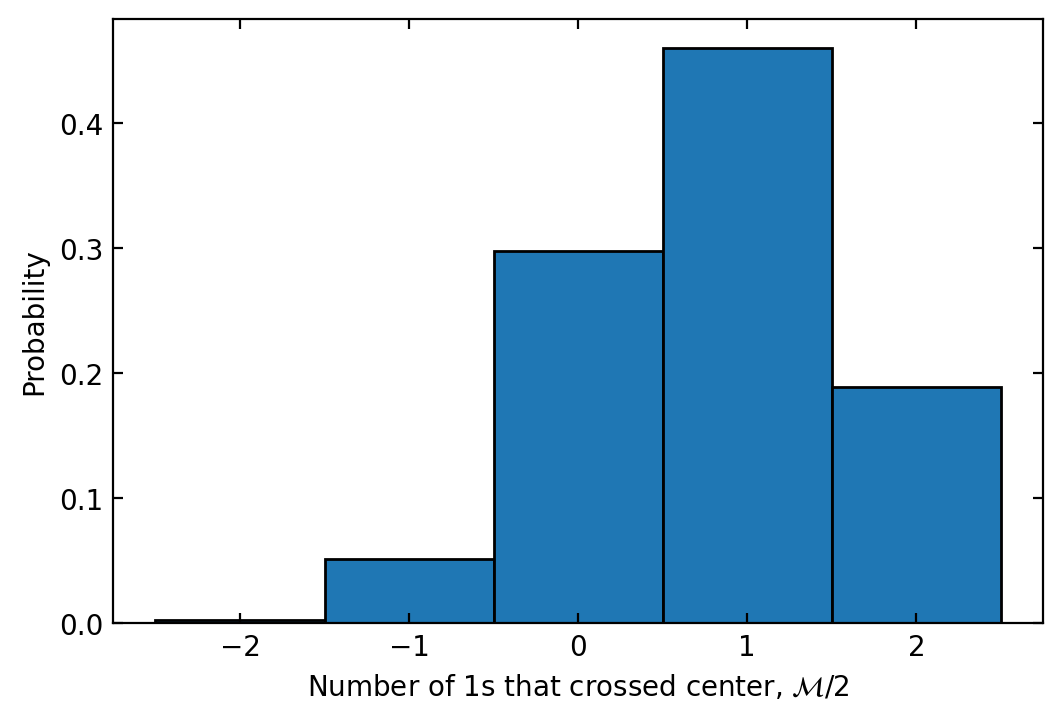

In [10]:
res_bitstrs.plot_histogram()

The same histogram can be obtained without any error from finite `reps` by using `res_amplitudes`:

<AxesSubplot: xlabel='Number of 1s that crossed center, $\\mathcal{M}/2$', ylabel='Probability'>

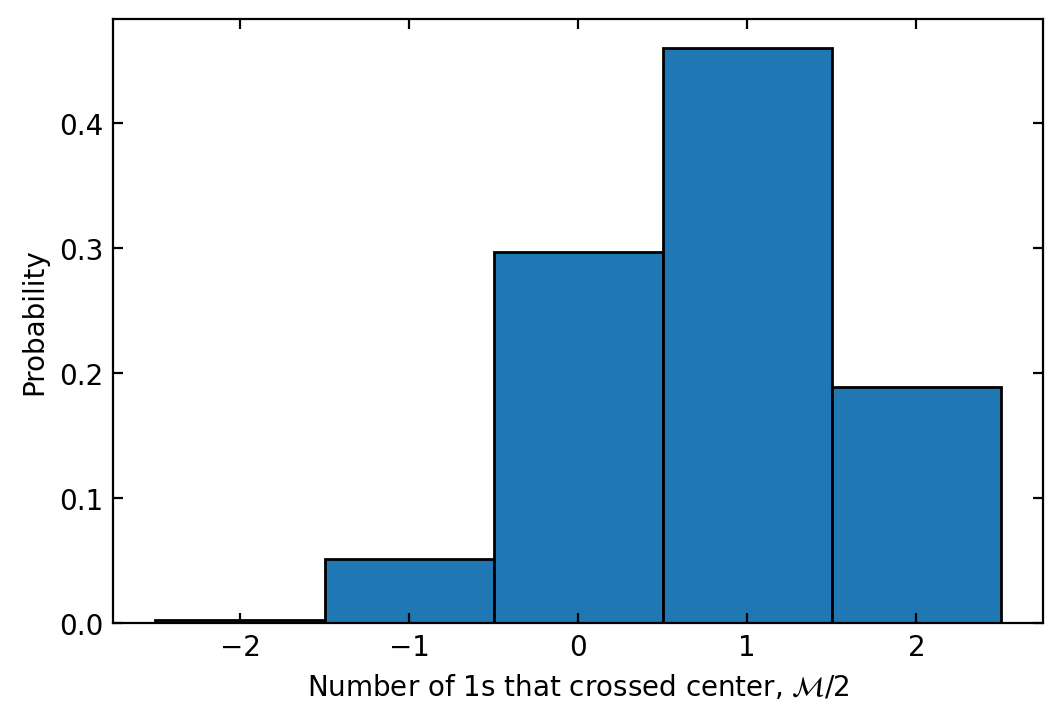

In [11]:
res_amplitudes.plot_histogram()

Finally, we are interested in the mean, variance, skewness, and kurtosis of this distribution. These are stored in `res_amplitudes.mean`, `res_amplitudes.variance`, `res_amplitudes.skewness`, and `res_amplitudes.kurtosis`, and similarly for `res_bitstrs`.

These quantities all have statistical uncertainty because we are sampling initial states. The statistical uncertainties can be computed with the `jackknife_mean()`, `jackknife_variance()`, `jackknife_skew()`, and `jackknife_kurtosis()` methods of either `res_amplitudes` or `res_bitstrs`. In particular, we have

In [12]:
print(f'mean = {res_amplitudes.mean:.2f} ± {res_amplitudes.jackknife_mean():.2f}')
print(f'variance = {res_amplitudes.variance:.1f} ± {res_amplitudes.jackknife_variance():.1f}')
print(f'skewness = {res_amplitudes.skewness:.2f} ± {res_amplitudes.jackknife_skew():.2f}')
print(f'kurtosis = {res_amplitudes.kurtosis:.1f} ± {res_amplitudes.jackknife_kurtosis():.1f}')

mean = 1.56 ± 0.04
variance = 2.7 ± 0.1
skewness = -0.26 ± 0.05
kurtosis = -0.3 ± 0.1


For the paper, we ran exact density matrix simulations up to cycle 8, which give, for this choice of $t=2$, $\mu=0.5$, and $(\theta, \phi) = (0.4\pi, 0.8\pi)$,

```
mean = 1.526
variance = 2.82
skewness = -0.287
kurtosis = -0.309
```
consistent with what we find by sampling initial states.

To test the conjecture that the late-time dynamics of this model are consistent with Kardar-Parisi-Zhang predictions, we care about how these moments of the transferred magnetization change over time. Here we compute these quantities up to cycle 9 (18 qubits). Note that the following cell takes at least about 10 minutes to run.

In [13]:
mean = []
d_mean = []
variance = []
d_variance = []
skewness = []
d_skewness = []
kurtosis = []
d_kurtosis = []

t = np.arange(1, 10)
for t_i in t:
    print('Starting t = {}'.format(t_i))
    expt = kpz.KPZExperiment(t_i, mu, num_init_states, theta, phi)
    res = expt.run_experiment_amplitudes(sampler)
    mean.append(res.mean)
    d_mean.append(res.jackknife_mean())
    variance.append(res.variance)
    d_variance.append(res.jackknife_variance())
    skewness.append(res.skewness)
    d_skewness.append(res.jackknife_skew())
    kurtosis.append(res.kurtosis)
    d_kurtosis.append(res.jackknife_kurtosis())

Starting t = 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1697.41it/s]


Starting t = 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 872.17it/s]


Starting t = 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 524.91it/s]


Starting t = 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 339.41it/s]


Starting t = 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 227.44it/s]


Starting t = 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 164.92it/s]


Starting t = 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.14it/s]


Starting t = 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:15<00:00, 62.85it/s]


Starting t = 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.51it/s]


Note that runtime is increasing exponentially $t$. The runtime, beyond $t=13$ or so, can be improved using GPUs if you have access to them, either using [qsim's built-in GPU backend](https://quantumai.google/reference/python/qsimcirq/QSimOptions), or [NVIDIA's cuQuantum](https://docs.nvidia.com/cuda/cuquantum/latest/appliance/cirq.html), the latter of which allows you to pool the resources of multiple GPUs. For instructions on picking hardware, see [this](https://quantumai.google/qsim/choose_hw) page, and for a tutorial on setting up the GPU backends, see [this](https://quantumai.google/qsim/tutorials/gcp_gpu) page. For the paper, we perform simulations to cycle 18 using 8 NVIDIA A100 GPUs.

Now, let's plot the observed moments of the transferred magnetization:

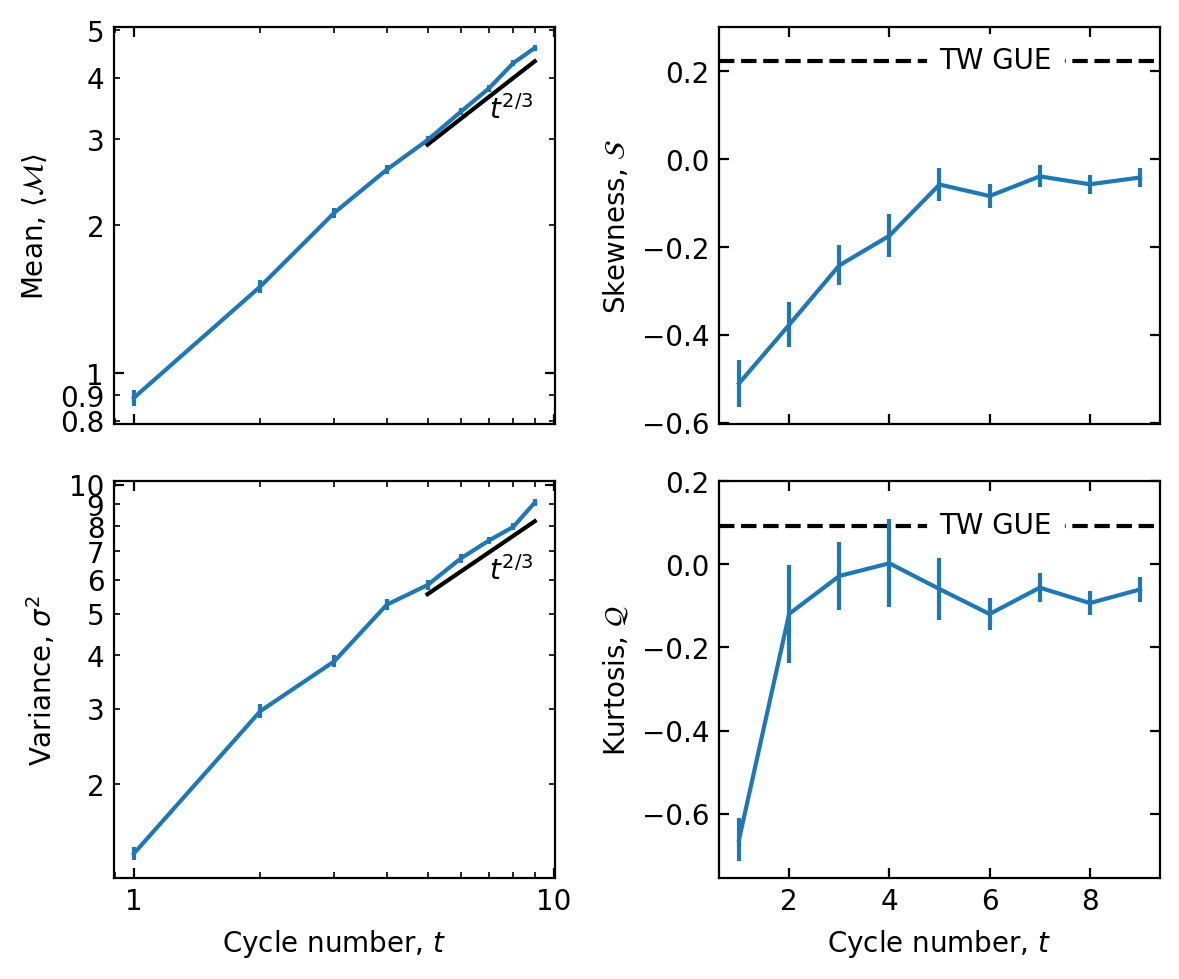

In [14]:
fig, ax = plt.subplots(2,2, figsize=(6,5), dpi=200, facecolor='white', sharex='col')
ax[0,0].errorbar(t, mean, d_mean)
ax[1,0].errorbar(t, variance, d_variance)
ax[0,1].errorbar(t, skewness, d_skewness, zorder=100)
ax[1,1].errorbar(t, kurtosis, d_kurtosis, zorder=100)

ax[0,0].set_ylabel('Mean, $\\langle \\mathcal{M} \\rangle$')
ax[1,0].set_ylabel('Variance, $\\sigma^2$')
ax[0,1].set_ylabel('Skewness, $\\mathcal{S}$')
ax[1,1].set_ylabel('Kurtosis, $\\mathcal{Q}$')
ax[1,0].set_xlabel('Cycle number, $t$')
ax[1,1].set_xlabel('Cycle number, $t$')

for _ in ax[:,0]:
    _.set_xscale('log')
    _.set_yscale('log')
    _.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2g"))
    _.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2g"))
    _.yaxis.set_minor_formatter(ticker.FormatStrFormatter("%.2g"))

t_ref = np.array([5,9])
ax[0,0].plot(t_ref, t_ref**(2/3), 'k')
ax[0,0].text(7,3.3, '$t^{2/3}$',)
ax[1,0].plot(t_ref, 1.9*t_ref**(2/3), 'k')
ax[1,0].text(7,6, '$t^{2/3}$',)

## TW GUE predictions:
ax[0,1].axhline(0.224, linestyle='--', color='k')
ax[0,1].text(np.mean(t),0.224, 'TW GUE', backgroundcolor='white', va='center', ha='left')
ax[1,1].axhline(0.093, linestyle='--', color='k')
ax[1,1].text(np.mean(t),0.093, 'TW GUE', backgroundcolor='white', va='center', ha='left')
ax[0,1].set_ylim(ax[0,1].get_ylim()[0], 0.3)
ax[1,1].set_ylim(ax[1,1].get_ylim()[0], 0.2)

for _ in ax.flatten():
    _.tick_params(direction='in', top=True, right=True, which='both')

plt.tight_layout()